This notebook shows some of the basic functionality of the DWD package including

- linear DWD (original SOCP formulation)
- gernalized DWD (gDWD)
- kernel gDWD
- faster cross-validation for gDWD
- multi-label classification

# sample sythetic training data

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
    
n_samples=100
sep = 2
n_features = 20
class_centers=[np.zeros(n_features),
               sep * np.ones(n_features) / np.sqrt(n_features)]

X, y = make_blobs(n_samples=100, n_features=20, centers=class_centers,
                  random_state=0)

# original DWD (SOCP formulation)

Notice the tuning parameter is C.

In [2]:
from dwd import DWD
dwd = DWD(C=.1).fit(X, y)

print('training accuracy:', dwd.score(X, y))

training accuracy: 0.91


### tuning with sklearn

In [3]:
from sklearn.model_selection import GridSearchCV

# do cross validation using Sklearn's grid search.
C_vals = np.logspace(-5, 5, 20)
clf = GridSearchCV(estimator=dwd, param_grid=dict(C=C_vals), cv=5,
                   n_jobs=-1, return_train_score=True)
clf.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DWD(C=0.1, solver_kws={}), iid='warn', n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

# generalized DWD

Notice the tuning parameter, C, is now lambda and we have another tuning parameter, q.

In [4]:
from dwd import GenDWD
dwd = GenDWD(lambd=.1, q=2).fit(X, y)

print('training accuracy:', dwd.score(X, y))

training accuracy: 0.92


### Faster cross-validation

By organizing the computation delicately we can compute the full cross-validation grid serach much more efficiently.

In [5]:
from dwd import GenDWDCV

dwd_cv = GenDWDCV(lambd_vals=np.logspace(-2, 2, 3),
                  q_vals=np.logspace(-2, 2, 2),
                  cv=5, scoring='roc_auc')

dwd_cv.fit(X, y)

print('training accuracy:', dwd_cv.score(X, y))

training accuracy: 0.89


# Kernel gDWD

In [6]:
from dwd import KernGDWD
kdwd = KernGDWD(lambd=1.0, q=1.0,
                kernel='rbf', kernel_kws={'gamma': .1}).fit(X, y)
kdwd.fit(X, y)

print('training accuracy:', kdwd.score(X, y))

training accuracy: 0.99


In [7]:
from dwd import KernGDWDCV

kdwd = KernGDWDCV(lambd_vals=np.logspace(-2, 2, 3),
                  q_vals=np.logspace(-2, 2, 2),
                  kernel='rbf',
                  kernel_kws_vals=[{'gamma': 1,
                                  'gamma': 2}]).fit(X, y)
kdwd.fit(X, y)

print('training accuracy:', kdwd.score(X, y))

training accuracy: 0.89


# Don't want to deal with sklearn API?

Don't worry we have a functional interface if you don't want to deal with the sklearn overhead.

Text(0, 0.5, 'objective function')

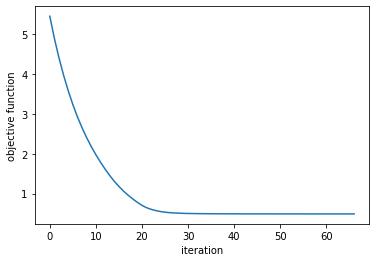

In [10]:
from dwd.gen_dwd import solve_gen_dwd
alpha, offset, obj_vals, c = solve_gen_dwd(X=X, y=y, lambd=.1)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(obj_vals)
plt.xlabel('iteration')
plt.ylabel('objective function')

# Multi-label classification


Currently multi-label classification is handeled with the one-vs-one or one-vs-rest strategy.

In [17]:
from sklearn.multiclass import OneVsRestClassifier
X, y = make_blobs(n_samples=100, n_features=20) # this makes 3 classes
print(len(set(y)))


clf = OneVsRestClassifier(GenDWD(lambd=.1)).fit(X, y)

print('training accuracy:', clf.score(X, y))

3
training accuracy: 0.95
